# Dataset Information Creation
Create a json file to represent the files inside the dataset

In [7]:
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import numpy as np
import json
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F
from tqdm import tqdm
from models.vanilla_cnn import AudioCNN
import torch.nn as nn
from utils import specs_generation, collect_samples
import os

In [2]:
# sudo modprobe nvidia_uvm
import torch
torch.cuda.is_available()

True

In [3]:
DATASET_NAME = "DATASET_CNN"
DATASET_PATH = f'../segments/{DATASET_NAME}'
TRAIN_PATH = f"{DATASET_PATH}/train"
TEST_PATH = f"{DATASET_PATH}/test"

# Create Dataset Config

In [4]:
with open("utils/category_annots.json") as f:
    category_annots = json.load(f)

filtered_species = [species for species in category_annots.keys() if len(species.split("_")) > 1]
mappings = {species: i for i, species in enumerate(filtered_species)}
mappings

{'Regulus ignicapilla_Common Firecrest': 0,
 'Sylvia atricapilla_Eurasian Blackcap': 1,
 'Fringilla coelebs_Common Chaffinch': 2,
 'Troglodytes troglodytes_Eurasian Wren': 3,
 'Muscicapa striata_Spotted Flycatcher': 4,
 'Phylloscopus collybita_Common Chiffchaff': 5,
 'Turdus viscivorus_Mistle Thrush': 6,
 'Glaucidium passerinum_Eurasian Pygmy-Owl': 7,
 'Pyrrhula pyrrhula_Eurasian Bullfinch': 8,
 'Periparus ater_Coal Tit': 9,
 'Prunella modularis_Dunnock': 10,
 'Lophophanes cristatus_Crested Tit': 11,
 'Regulus regulus_Goldcrest': 12,
 'Turdus merula_Eurasian Blackbird': 13,
 'Certhia familiaris_Eurasian Treecreeper': 14,
 'Erithacus rubecula_European Robin': 15,
 'Turdus philomelos_Song Thrush': 16,
 'Loxia curvirostra_Common Crossbill': 17,
 'Dendrocopos major_Great Spotted Woodpecker': 18,
 'Dryocopus martius_Black Woodpecker': 19,
 'Phylloscopus trochilus_Willow Warbler': 20,
 'Spinus spinus_Eurasian Siskin': 21,
 'Poecile palustris_Marsh Tit': 22}

In [5]:
samples = collect_samples(TRAIN_PATH, TEST_PATH, mappings)

In [6]:
dataset_config = {
    "mappings": mappings,
    "samples": samples
}

In [20]:
with open(f"utils/{DATASET_NAME}/dataset_config.json", "w") as f:
    json.dump(dataset_config, f)

# Spectograms Creation

In [8]:
SPECS_TRAIN_PATH = f"{DATASET_PATH}/train_specs"
SPECS_TEST_PATH = f"{DATASET_PATH}/test_specs"
os.makedirs(SPECS_TRAIN_PATH, exist_ok=True)
os.makedirs(SPECS_TEST_PATH, exist_ok=True)
specs_generation(TRAIN_PATH, SPECS_TRAIN_PATH, dataset_config['mappings'])
specs_generation(TEST_PATH, SPECS_TEST_PATH, dataset_config['mappings'])

Processing: Muscicapa striata_Spotted Flycatcher
Processing: Periparus ater_Coal Tit
Processing: Regulus regulus_Goldcrest
Processing: Glaucidium passerinum_Eurasian Pygmy-Owl
Processing: Troglodytes troglodytes_Eurasian Wren
Processing: Erithacus rubecula_European Robin
Processing: Dryocopus martius_Black Woodpecker
Processing: Poecile palustris_Marsh Tit
Processing: Certhia familiaris_Eurasian Treecreeper
Processing: Phylloscopus collybita_Common Chiffchaff
Processing: Phylloscopus trochilus_Willow Warbler
Processing: Pyrrhula pyrrhula_Eurasian Bullfinch
Processing: Turdus merula_Eurasian Blackbird
Processing: Loxia curvirostra_Common Crossbill
Processing: Regulus ignicapilla_Common Firecrest
Processing: Dendrocopos major_Great Spotted Woodpecker
Processing: Turdus viscivorus_Mistle Thrush
Processing: Spinus spinus_Eurasian Siskin
Processing: Sylvia atricapilla_Eurasian Blackcap
Processing: Lophophanes cristatus_Crested Tit
Processing: Fringilla coelebs_Common Chaffinch
Processing: T

Shape: torch.Size([256, 256])


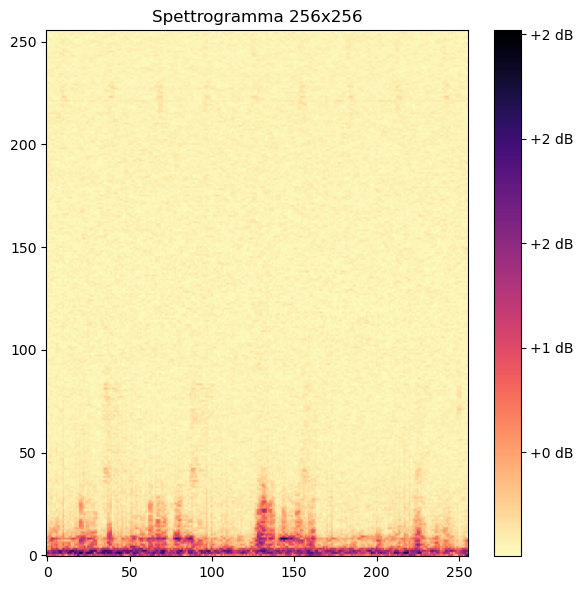

In [ ]:
# carica lo spettrogramma salvato
spec_path = "/home/giacomoschiavo/segments/DATASET_CNN/test_specs/Dendrocopos major_Great Spotted Woodpecker/20200215_120000_417_0.pt"  # cambia path se serve
spec = torch.load(spec_path)

# controlla la shape per capire cosa stai guardando
print("Shape:", spec.shape)  # dovrebbe essere (256, 256)

# Plot semplice e clean
plt.figure(figsize=(6, 6))
plt.imshow(spec.numpy(), origin='lower', aspect='auto', cmap='magma_r')
plt.title("Spettrogramma 256x256")
plt.colorbar(format="%+2.f dB")
plt.tight_layout()
plt.show()


# Dataset and Data Loader
Use the dataset information to create a data loader for the model

In [14]:
def wav_to_spec(audio_path):
    split = audio_path.split("/")[-3]
    audio = audio_path.replace("wav", "pt").replace(split, f"{split}_specs")
    return audio

In [24]:
class CachedAudioDataset(Dataset):
    def __init__(self, dataset_config, split="train"):
        self.samples = [s for s in dataset_config["samples"] if s["split"] == split]
        self.num_classes = len(dataset_config["mappings"])
        
        # Carica tutto in RAM
        self.cache = []
        for sample in self.samples:
            spec = torch.load(wav_to_spec(sample["file_path"]))  # spettrogramma
            label_tensor = torch.zeros(self.num_classes)
            for label in sample["labels"]:
                label_tensor[label] = 1.0
            self.cache.append((spec, label_tensor, sample["file_path"]))

    def __len__(self):
        return len(self.cache)

    def __getitem__(self, idx):
        return self.cache[idx]


In [20]:
from torch.utils.data import DataLoader

def get_dataloader(dataset_config, split="train", batch_size=100, shuffle=True):
    dataset = CachedAudioDataset(dataset_config=dataset_config, split=split)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Model

In [ ]:
def train_model(dataset_config, epochs=10, batch_size=100, lr=0.00001, print_freq=100):
    history_loss = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on: {device}")

    print("Loading training data...")
    train_loader = get_dataloader(dataset_config, split="train", batch_size=batch_size)
    print("Loaded!")
    num_classes = len(dataset_config['mappings'])

    model = AudioCNN(num_classes).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        print(f"\n🎯 Starting epoch {epoch + 1}/{epochs}")

        for batch_index, (mel_spec, labels, _) in enumerate(train_loader):
            mel_spec = mel_spec.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(mel_spec)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            

            if batch_index % print_freq == 0:
                print('Epoch: [{0}][{1}/{2}], Loss: {loss:.5f}'.format(epoch, batch_index, len(train_loader), loss=loss))

        avg_loss = running_loss / len(train_loader)
        history_loss.append(running_loss)


    print("✅ Training completed")
    return model, history_loss


In [47]:
model, history_loss = train_model(dataset_config, epochs=5, batch_size=25)

Training on: cuda
Loading training data...
Loaded!

🎯 Starting epoch 1/5
Epoch: [0][0/539], Loss: 0.931
Epoch: [0][100/539], Loss: 0.930
Epoch: [0][200/539], Loss: 0.924
Epoch: [0][300/539], Loss: 0.887
Epoch: [0][400/539], Loss: 0.813
Epoch: [0][500/539], Loss: 0.740

🎯 Starting epoch 2/5
Epoch: [1][0/539], Loss: 0.727
Epoch: [1][100/539], Loss: 0.706
Epoch: [1][200/539], Loss: 0.697
Epoch: [1][300/539], Loss: 0.696
Epoch: [1][400/539], Loss: 0.696
Epoch: [1][500/539], Loss: 0.695

🎯 Starting epoch 3/5
Epoch: [2][0/539], Loss: 0.695
Epoch: [2][100/539], Loss: 0.694
Epoch: [2][200/539], Loss: 0.694
Epoch: [2][300/539], Loss: 0.694
Epoch: [2][400/539], Loss: 0.694
Epoch: [2][500/539], Loss: 0.694

🎯 Starting epoch 4/5
Epoch: [3][0/539], Loss: 0.694
Epoch: [3][100/539], Loss: 0.693
Epoch: [3][200/539], Loss: 0.693
Epoch: [3][300/539], Loss: 0.694
Epoch: [3][400/539], Loss: 0.693
Epoch: [3][500/539], Loss: 0.693

🎯 Starting epoch 5/5
Epoch: [4][0/539], Loss: 0.694
Epoch: [4][100/539], Los

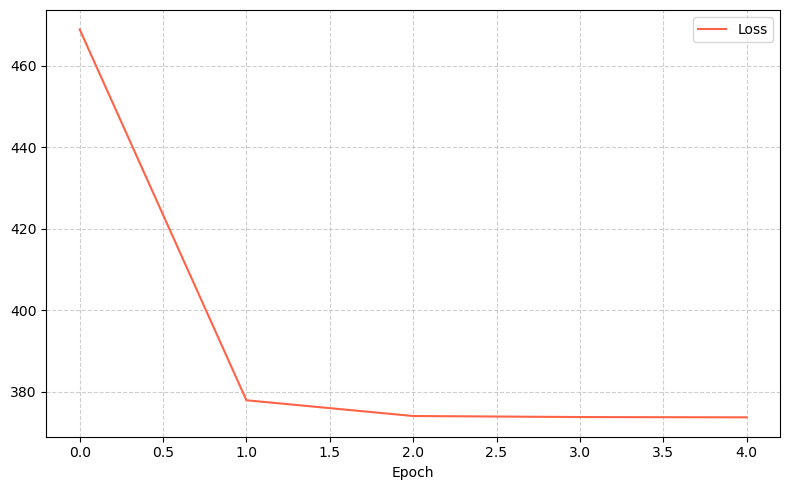

In [48]:
plt.figure(figsize=(8, 5))
plt.plot(history_loss, linestyle='-', color='tomato', label="Loss")
# plt.title(title)
plt.xlabel("Epoch")
# plt.ylabel(ylabel)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [49]:
from sklearn.metrics import classification_report, roc_auc_score, multilabel_confusion_matrix
import numpy as np

def test_model(model, dataset_config, batch_size=100, threshold=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n🧬 Advanced testing on: {device}")

    test_loader = get_dataloader(dataset_config, split="test", batch_size=batch_size, shuffle=False)
    model.eval()
    criterion = nn.BCEWithLogitsLoss()

    total_loss = 0.0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for mel_spec, labels, _ in test_loader:
            mel_spec = mel_spec.to(device)
            labels = labels.to(device)

            outputs = model(mel_spec)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float()

            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    avg_loss = total_loss / len(test_loader)
    all_probs = torch.cat(all_probs).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # 👇 Report
    print("\n📋 Classification Report (Multi-label):")
    print(classification_report(all_labels, all_preds, target_names=dataset_config["mappings"], zero_division=0))

    # 🎯 ROC AUC (solo se c'è più di una classe positiva per classe)
    # try:
    #     auc = roc_auc_score(all_labels, all_probs, average='macro')
    #     print(f"🩸 Macro AUC: {auc:.4f}")
    # except ValueError:
    #     print("⚠️  AUC non calcolabile: alcune classi hanno solo 0 nei label.")

    # # 💥 Confusion Matrix per ogni classe
    # cm = multilabel_confusion_matrix(all_labels, all_preds)
    # for idx, label in enumerate(dataset_config["mappings"]):
    #     tn, fp, fn, tp = cm[idx].ravel()
    #     print(f"\n🔍 Classe: {label}")
    #     print(f"  TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

    return avg_loss


In [50]:
test_model(model, dataset_config)


🧬 Advanced testing on: cuda



📋 Classification Report (Multi-label):
                                            precision    recall  f1-score   support

      Regulus ignicapilla_Common Firecrest       0.22      1.00      0.36       823
      Sylvia atricapilla_Eurasian Blackcap       0.38      1.00      0.55      1445
        Fringilla coelebs_Common Chaffinch       0.71      1.00      0.83      2702
     Troglodytes troglodytes_Eurasian Wren       0.04      1.00      0.08       149
      Muscicapa striata_Spotted Flycatcher       0.04      1.00      0.08       159
  Phylloscopus collybita_Common Chiffchaff       0.00      0.00      0.00         0
           Turdus viscivorus_Mistle Thrush       0.00      0.00      0.00         0
  Glaucidium passerinum_Eurasian Pygmy-Owl       0.01      1.00      0.01        27
      Pyrrhula pyrrhula_Eurasian Bullfinch       0.01      1.00      0.02        31
                   Periparus ater_Coal Tit       0.04      1.00      0.08       151
                Prunella modularis_

0.6930334568023682